In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
import numpy as np
from scipy.stats import norm
from collections import defaultdict
from math import log, pi, exp, sqrt
from scipy.stats import kstest, norm



In [2]:

data = pd.read_csv('lifeInsurance.txt', header = None, sep= '\s+')
data.columns = ['GENDER', 'AGE', 'Marital Status', 'Nmr of children', 'Life Style', 'Chronic Diseases', 'Salary (monthly)', 'Decision']  



In [3]:
print(data.head())

# plt.show()


   GENDER    AGE  Marital Status  Nmr of children  Life Style  \
0     0.0   80.0             1.0              1.0         1.0   
1     0.0  101.0             1.0              3.0         1.0   
2     0.0   34.0             1.0              3.0         1.0   
3     0.0   34.0             0.0              1.0         1.0   
4     0.0   93.0             1.0              2.0         1.0   

   Chronic Diseases  Salary (monthly)  Decision  
0               0.0         2611.4159       0.0  
1               1.0         3132.2018       1.0  
2               1.0         2462.3115       1.0  
3               1.0         3051.9166       0.0  
4               1.0         2401.4440       1.0  


In [4]:
weigths = {
    'AGE': {
        '< 30': 5,
        '30-40': 10,
        '40-50': 15,
        '> 50': 20,
    },
    'Chronic Diseases': {
        '0': 5,
        '1': 10,
        '2': 15
    },
    'Salary (monthly)' : {
        '> 3500': 5,
        '1700-3500': 10,
        '< 1700': 15
    }, 
    'Nmr of children': {
        '0': 5,
        '1': 10,
        '> 1': 15
    }

}

In [5]:
def calculate_score(row):

    score = 0   


    if row['AGE'] < 30:
        score += weigths['AGE']['< 30']
    elif 30 <= row['AGE'] < 40:
        score += weigths['AGE']['30-40']
    elif 40 <= row['AGE'] < 50:
        score += weigths['AGE']['40-50']
    else:
        score += weigths['AGE']['> 50']


    if row['Chronic Diseases'] == 0:
        score += weigths['Chronic Diseases']['0']
    elif row['Chronic Diseases'] == 1:
        score += weigths['Chronic Diseases']['1']
    else:
        score += weigths['Chronic Diseases']['2']


    if row['Salary (monthly)'] <= 1700:
        score += weigths['Salary (monthly)']['< 1700']
    elif 1700 < row['Salary (monthly)'] <= 3500:
        score += weigths['Salary (monthly)']['1700-3500']
    else:
        score += weigths['Salary (monthly)']['> 3500']


    if row['Nmr of children'] == 0:
        score += weigths['Nmr of children']['0']
    elif row['Nmr of children'] == 1:
        score += weigths['Nmr of children']['1']
    else:
        score += weigths['Nmr of children']['> 1']
    
    return score


In [6]:
def bayesian_insurance_decision(dataset):
    # Criar uma cópia do dataset para não modificar o original
    df = dataset.copy()
    
    # Calcular a pontuação para cada pessoa
    df['Score'] = df.apply(calculate_score, axis=1)
    
    # Determinar a decisão com base na pontuação
    df['Predicted Decision'] = df['Score'].apply(lambda x: 'Yes' if x > 50 else 'No')
    
    return df

In [7]:
result = bayesian_insurance_decision(data)
# print(result)

In [8]:
result['Decision'] = result['Decision'].replace({0.0: 'No', 1.0: 'Yes'})

accuracy_companhia = 0

for _, row in result.iterrows():  # Usar iterrows() para iterar sobre as linhas do DataFrame
    if row['Predicted Decision'] == row['Decision']:
        accuracy_companhia += 1

print(f"How many correct predictions: {accuracy_companhia}")
size = len(result)
print(f"Size: {size}")
print(f"Accuracy: {accuracy_companhia / len(result) * 100:.2f}%")

How many correct predictions: 456
Size: 600
Accuracy: 76.00%


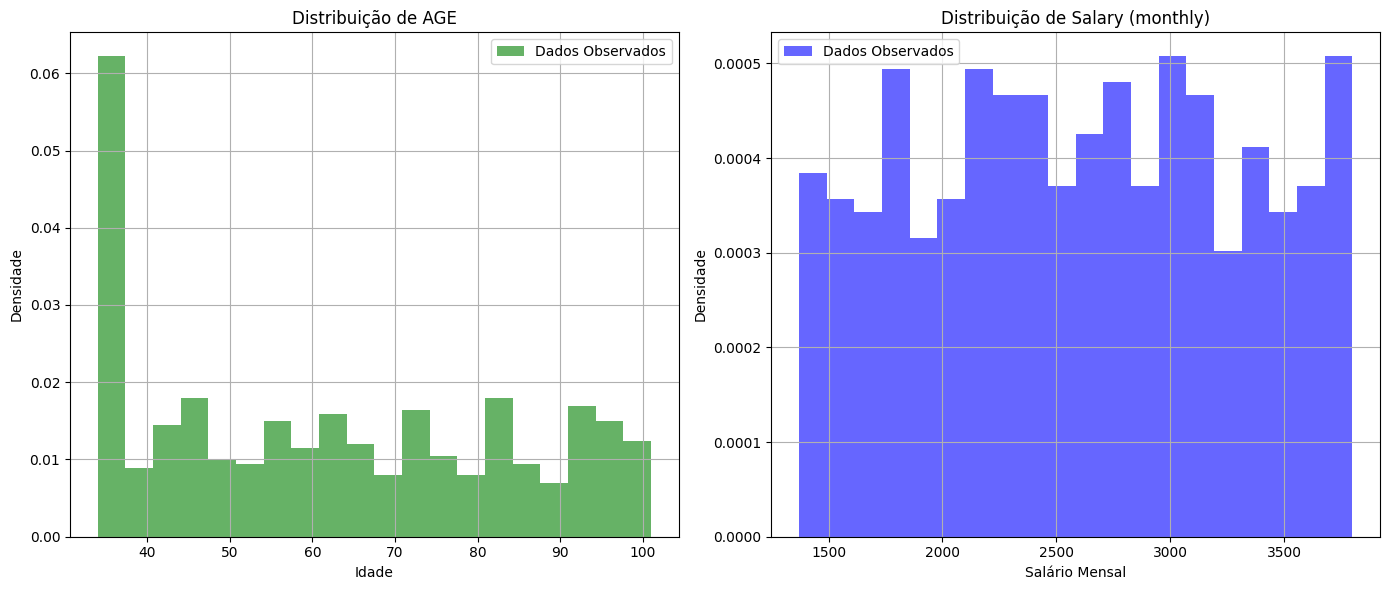

In [9]:
plt.figure(figsize=(14, 6))

# --- Gráfico 1: Distribuição de AGE ---
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
plt.hist(data["AGE"], bins=20, density=True, alpha=0.6, color='green', label='Dados Observados')
xmin, xmax = plt.xlim()
x_age = np.linspace(xmin, xmax, 100)
# plt.plot(x_age, norm.pdf(x_age, media_age, desvio_padrao_age), 'k-', linewidth=2,
        #  label=f'Normal (μ={media_age:.1f}, σ={desvio_padrao_age:.1f})')
plt.title('Distribuição de AGE')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)

# --- Gráfico 2: Distribuição de Salary (monthly) ---
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
plt.hist(data['Salary (monthly)'], bins=20, density=True, alpha=0.6, color='blue', label='Dados Observados')
xmin, xmax = plt.xlim()
x_salary = np.linspace(xmin, xmax, 100)
# plt.plot(x_salary, norm.pdf(x_salary, media_salary, desvio_padrao_salary), 'k-', linewidth=2,
        #  label=f'Normal (μ={media_salary:.1f}, σ={desvio_padrao_salary:.1f})')
plt.title('Distribuição de Salary (monthly)')
plt.xlabel('Salário Mensal')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)

# Ajuste de layout e exibição
plt.tight_layout()
# plt.savefig('distribuicoes.png')
plt.show()


In [18]:
# o que queres ver começa realmente aqui

############# TESTE DE KOLMOGOROV-SMIRNOV (KS) #############

media_age = data['AGE'].mean()  
desvio_padrao_age = data['AGE'].std(ddof=0)  # ddof=0 para população, ddof=1 para amostra

media_salary = data['Salary (monthly)'].mean()
desvio_padrao_salary = data['Salary (monthly)'].std(ddof=0)


# Teste KS para AGE
ks_stat_age, p_valor_age = kstest(
    data['AGE'], 
    'norm', 
    args=(media_age, desvio_padrao_age)  # args: (mean, std)
)

# Teste KS para Salary
ks_stat_salary, p_valor_salary = kstest(
    data['Salary (monthly)'], 
    'norm', 
    args=(media_salary, desvio_padrao_salary)
)

# Resultados
print(f" Age KS = {ks_stat_age:.4f}, p-value = {p_valor_age:.4f}")
print(f" Salary  KS = {ks_stat_salary:.4f}, p-value = {p_valor_salary:.4f}")

 Age KS = 0.1040, p-value = 0.0000
 Salary  KS = 0.0560, p-value = 0.0448


In [11]:
data = data[['AGE', 'Salary (monthly)', 'Chronic Diseases', 'Nmr of children', 'Decision']]


########## Log  vai aqui ################

data = data[(data['AGE'] > 0) & (data['Salary (monthly)'] > 0)]  # evitar log(0)
data['log_AGE'] = np.log(data['AGE'])
data['log_SALARY'] = np.log(data['Salary (monthly)'])

In [12]:
X = data[['log_AGE', 'log_SALARY', 'Chronic Diseases', 'Nmr of children']]
y = data['Decision']

# Separar os dados por classe
class_labels = y.unique()
class_data = {label: X[y == label] for label in class_labels}

In [13]:
def estimate_parameters(class_df):
    params = {}
    # Para log_AGE e log_SALARY (contínuas): média e desvio padrão
    for col in ['log_AGE', 'log_SALARY']:
        mu = class_df[col].mean()
        sigma = class_df[col].std()
        params[col] = (mu, sigma)
    
    # Para variáveis discretas: probabilidade empírica
    for col in ['Chronic Diseases', 'Nmr of children']:
        freqs = class_df[col].value_counts(normalize=True).to_dict()
        params[col] = freqs

    return params

params_per_class = {label: estimate_parameters(df) for label, df in class_data.items()}



In [14]:
#  Prior de cada classe
priors = {label: len(class_data[label]) / len(X) for label in class_labels}

In [ ]:

# Função de densidade da log-normal
def lognorm_pdf(x, mu, sigma):
    if x <= 0 or sigma <= 0:
        return 1e-12
    return (1 / (x * sigma * sqrt(2 * pi))) * exp(-((log(x) - mu) ** 2) / (2 * sigma ** 2))

# Como estamos a usar log(AGE) e log(SALARY), o log-normal ficaq normal diretamente:
def normal_pdf(x, mu, sigma):
    if sigma <= 0:
        return 1e-12
    return (1 / (sigma * sqrt(2 * pi))) * exp(-((x - mu) ** 2) / (2 * sigma ** 2))


def predict_instance(instance):
    posteriors = {}
    for label in class_labels:
        prob = log(priors[label])  # log para evitar underflow
        params = params_per_class[label]

        # Contínuas (log_AGE, log_SALARY)
        for col in ['log_AGE', 'log_SALARY']:
            mu, sigma = params[col]
            likelihood = normal_pdf(instance[col], mu, sigma)
            prob += log(likelihood + 1e-12)

        # Discretas
        for col in ['Chronic Diseases', 'Nmr of children']:
            val = instance[col]
            likelihood = params[col].get(val, 1e-6)  # Laplace smoothing
            prob += log(likelihood)

        posteriors[label] = prob
    return max(posteriors, key=posteriors.get)



In [ ]:

preds = X.apply(predict_instance, axis=1)


data['PredictedDecision'] = preds.values


correct = (preds == y).sum()
accuracy_bayesian = correct / len(y)

print(f"Correct predictions: {correct}/{len(y)}")
print(f"Accuracy: {accuracy_bayesian * 100:.2f}%")


# errors = data[data['PredictedDecision'] != data['Decision']]
# print(errors)



Correct predictions: 498/600
Accuracy: 83.00%


In [17]:
print(f'''Life ensurance score point method accuracy ({accuracy_companhia / len(result) * 100:.2f}%) < Bayesian Inference method accuracy ({accuracy_bayesian * 100:.2f}%).''')

Life ensurance score point method accuracy (76.00%) < Bayesian Inference method accuracy (83.00%).
